In [19]:
import io
import math

import torch
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import datasets, train, models

import pytorch_lightning as pl

from compressai.zoo import bmshj2018_hyperprior

In [20]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [21]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp
    
def mse(a, b):
    a = np.asarray(a).astype(np.float32)
    b = np.asarray(b).astype(np.float32)
    return np.mean(np.square(a - b))

def psnr(a, b):
        return psnr_from_mse(mse(a, b))
    
def psnr_from_mse(mse, max_value=255):
        return 20 * math.log10(max_value) - 10. * math.log10(mse)

In [22]:
def plot_rate_distortion_curves(data):

    
    for model_name, (bpps, dists) in data.items():
        if model_name == "JPEG":
            data_range = 255
        else:
            data_range = 1
        
        plt.plot(bpps, tuple(psnr_from_mse(d, data_range) for d in dists), 'o-')
        

    plt.legend(data.keys())
    plt.title("Rate-Distortion Curves")
    plt.xlabel("Bites Per Pixel")
    plt.ylabel("PSNR")
    plt.show()

In [23]:
def compare_with_classical(rec_net, original_image, target_bpp):
    rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, original_image, fmt="jpeg")
    rec_webp, bpp_webp = find_closest_bpp(target_bpp, original_image, fmt='webp')

    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    for ax in axes.ravel():
        ax.axis('off')

    fig.title = 'yolo'
    axes[0][0].imshow(original_image)
    axes[0][0].title.set_text('Original')
    axes[0][1].imshow(rec_net)
    axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp, {mse(rec_net, original_image):.2f} mse')
    axes[1][0].imshow(rec_jpeg)
    axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp, {mse(rec_jpeg, original_image):.2f} mse')
    axes[1][1].imshow(rec_webp)
    axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp, {mse(rec_webp, original_image):.2f} mse')

    plt.show()

In [24]:
def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [25]:
def run_pretrained_model(image, model, quality, verbose=True):
    device = 'cpu'

    net = model(quality=quality, pretrained=True).eval().to(device)

    if type(image) == torch.Tensor:
        x = image
    else:
        x = transforms.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out_net = net.forward(x)
    
    out_net['x_hat'].clamp_(0, 1)

    if type(image) == torch.Tensor:
        rec_net = out_net['x_hat'].squeeze().cpu()
    else:
        rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    
    if verbose:
        print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

    return compute_bpp(out_net), rec_net

In [26]:
def mse_across_tasks(batch, model):
    """
    We want to return an list of mse and bpp values for each task
    """
    
    ans = {key: tuple((list(), list())) for key in batch.keys()}


    # for all tasks
    for task, image_tensors in batch.items():
        # for all bpp values
        
        if model == "JPEG":
            for bpp in (0.2, 0.5, 0.8, 1, 2):        

                batch_bpps = []
                batch_mses = []

                # for all images of the task in a batch
                for image_tensor in image_tensors:

                    image = transforms.ToPILImage()(image_tensor)

                    reconstruction, bpp = find_closest_bpp(bpp, image)

                    batch_mses.append(mse(reconstruction, image))
                    batch_bpps.append(bpp)
                    
                ans[task][0].append(np.mean(batch_bpps))
                ans[task][1].append(np.mean(batch_mses))

        elif model == "pretr":
            for quality in (1, 2, 3, 4, 5):
                
                if task == "depth_euclidean":
                    input_data = (image_tensors/image_tensors.max()).repeat(1, 3, 1, 1)
                else:
                    input_data = image_tensors

                bpp, reconstructions = run_pretrained_model(input_data, bmshj2018_hyperprior, quality, False)
                
                ans[task][0].append(bpp)
                ans[task][1].append(mse(reconstructions, input_data))
        else:
            raise NotImplementedError()

    mean_bpp = np.mean(list(np.array(ans[task][0]) for task in ans.keys()), axis=0)
    mean_mse = np.mean(list(np.array(ans[task][1]) for task in ans.keys()), axis=0)
    
    return ans, (mean_bpp, mean_mse)


In [40]:
pl.seed_everything(21)

MODEL_PATH = "../model-4-01.ckpt"
TASKS = ["rgb", "depth_euclidean", "normal"]
DATASET = "clevr"

default_collate = datasets.transforms.make_collate_fn(TASKS)

_, dataloader = train.get_dataloader(
    dataset_name=DATASET,
    batch_size=16,
    num_workers=0,
    tasks=TASKS,
    is_train=True,
    collate=default_collate,
)

Global seed set to 21


In [41]:
TASK = "rgb"

batch = next(iter(dataloader))
original_image = transforms.ToPILImage()(batch[TASK][0])

In [43]:
ckpt_params = torch.load(MODEL_PATH, map_location="cpu")

model_type = models.MultiTaskMixedLatentCompressor
model_type = models.MultiTaskSharedLatentCompressor

compressor = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor.load_state_dict(ckpt_params["state_dict"])
compressor.update_bottleneck_values()

compressed_data, bytes = compressor.compress(batch, print_info=True)
strings, shape = compressed_data["strings"], compressed_data["shape"]

decompressed_batch = compressor.decompress(strings, shape)

decompressed_image = decompressed_batch[TASK][0].detach()

decompressed_image_pil = transforms.ToPILImage()(decompressed_image)

Number of actual bytes in a string is: 38616, which gives a BPP = 0.10
Estimated BPP (compression loss) is: 0.10


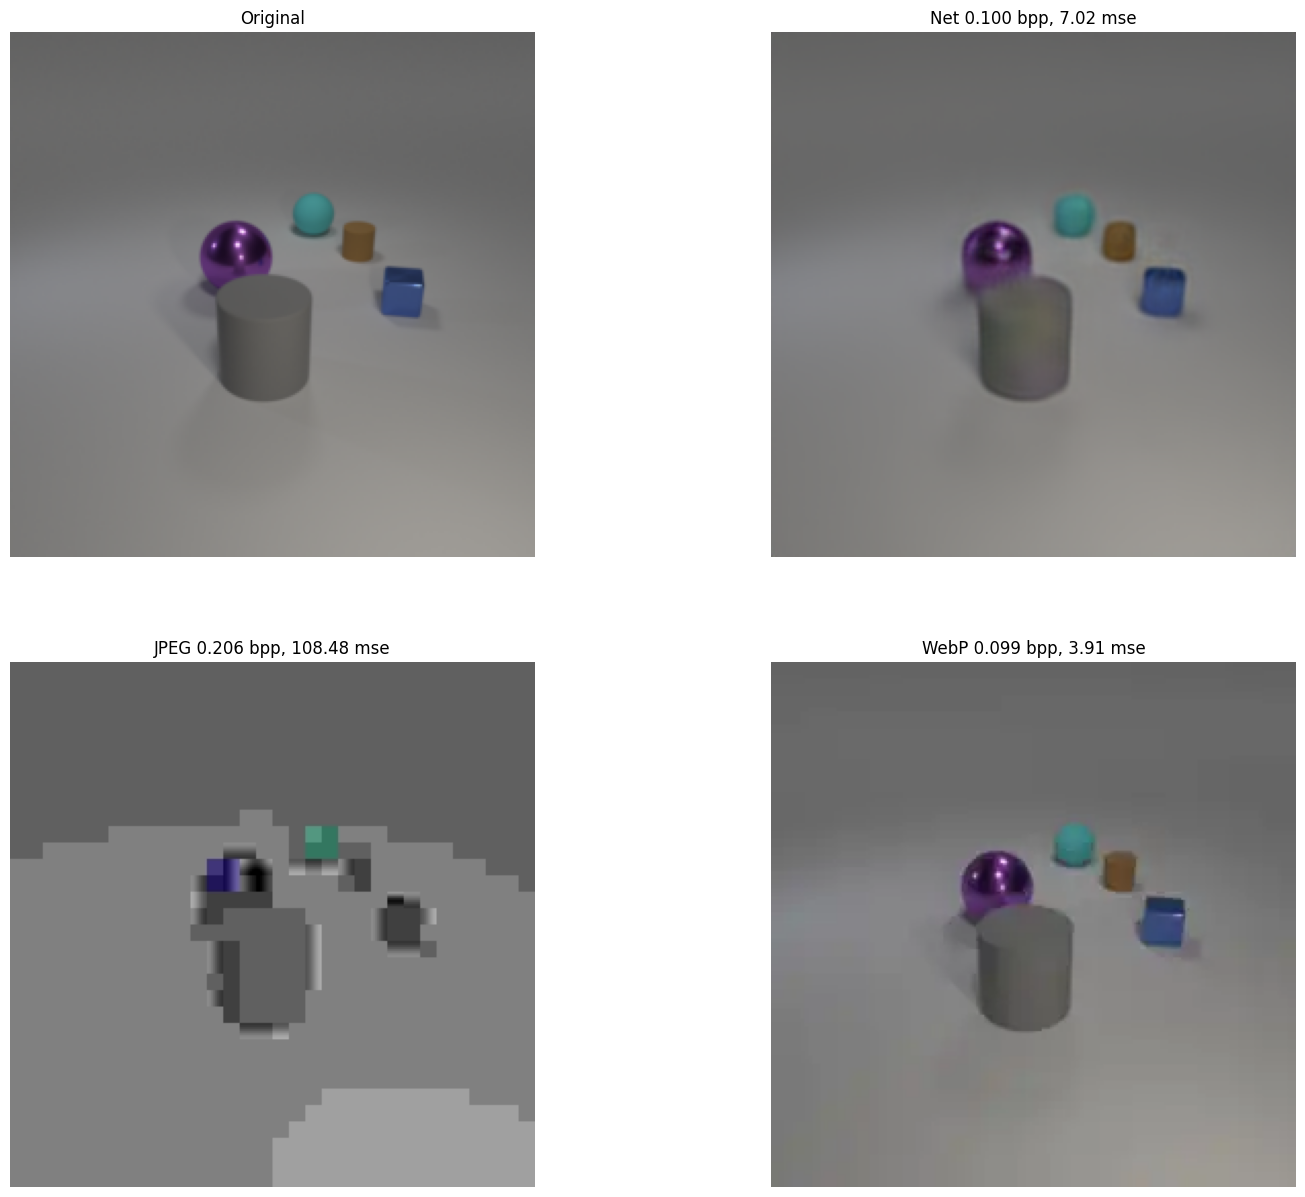

In [45]:
compare_with_classical(decompressed_image_pil, original_image, target_bpp=0.1)

---

But this is for RGB natural looking images. Will it also outperform on normals?

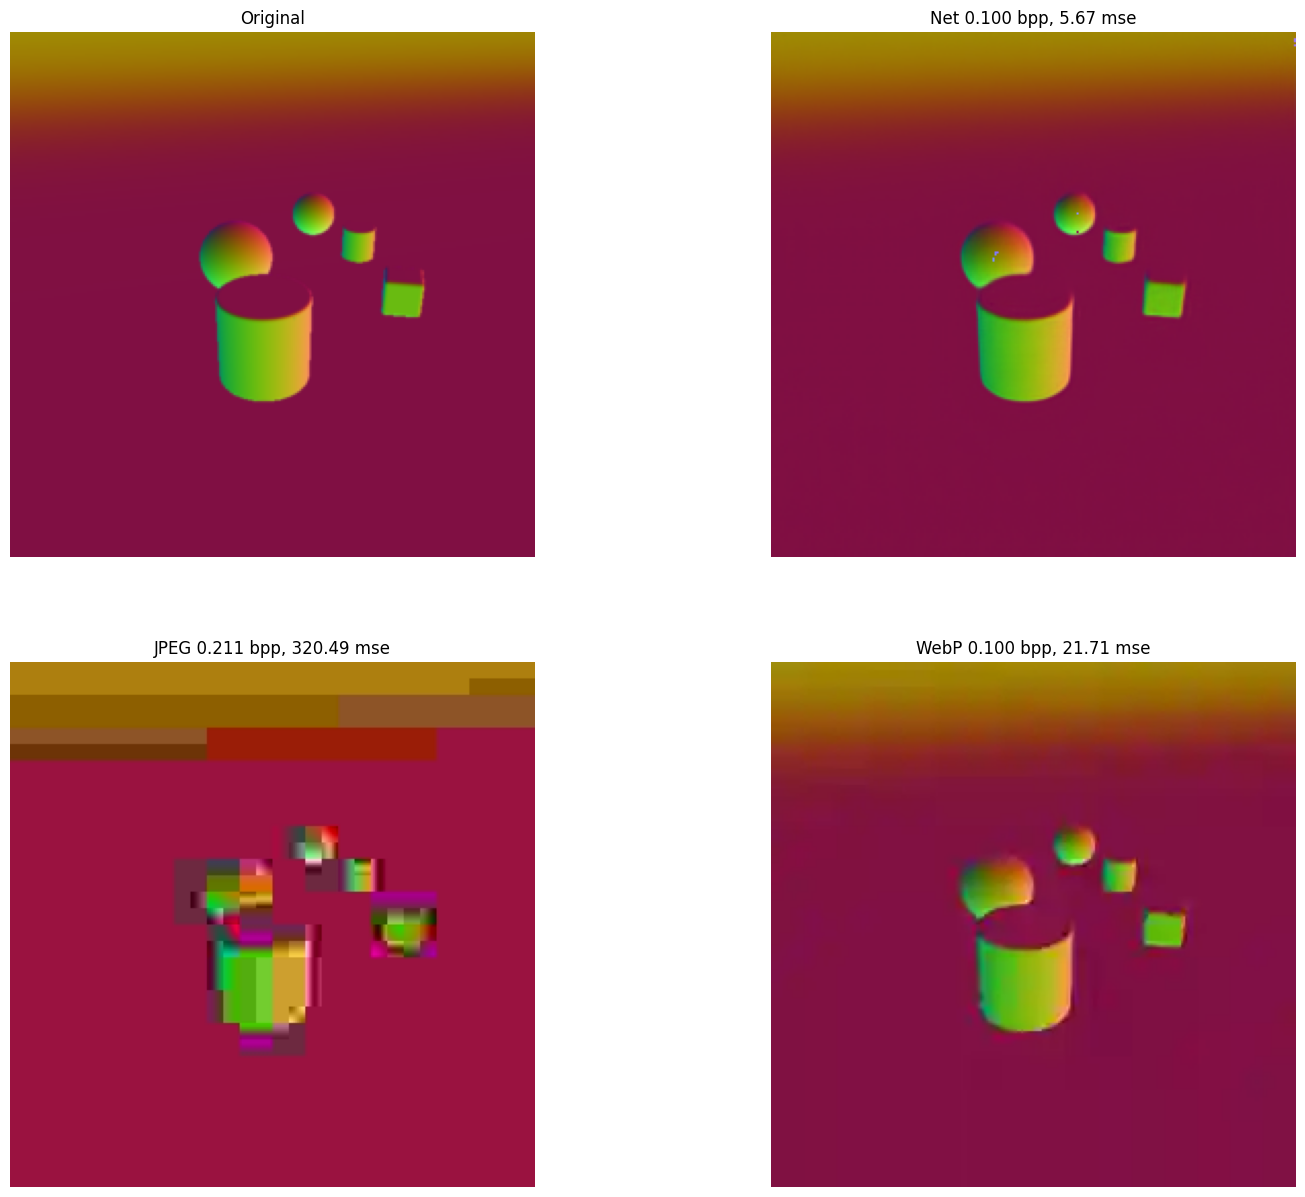

In [49]:
decompressed_image_pil = transforms.ToPILImage()(decompressed_batch["normal"][0].detach())
compare_with_classical(decompressed_image_pil, original_image, target_bpp=0.1)

Parameters: 5075843


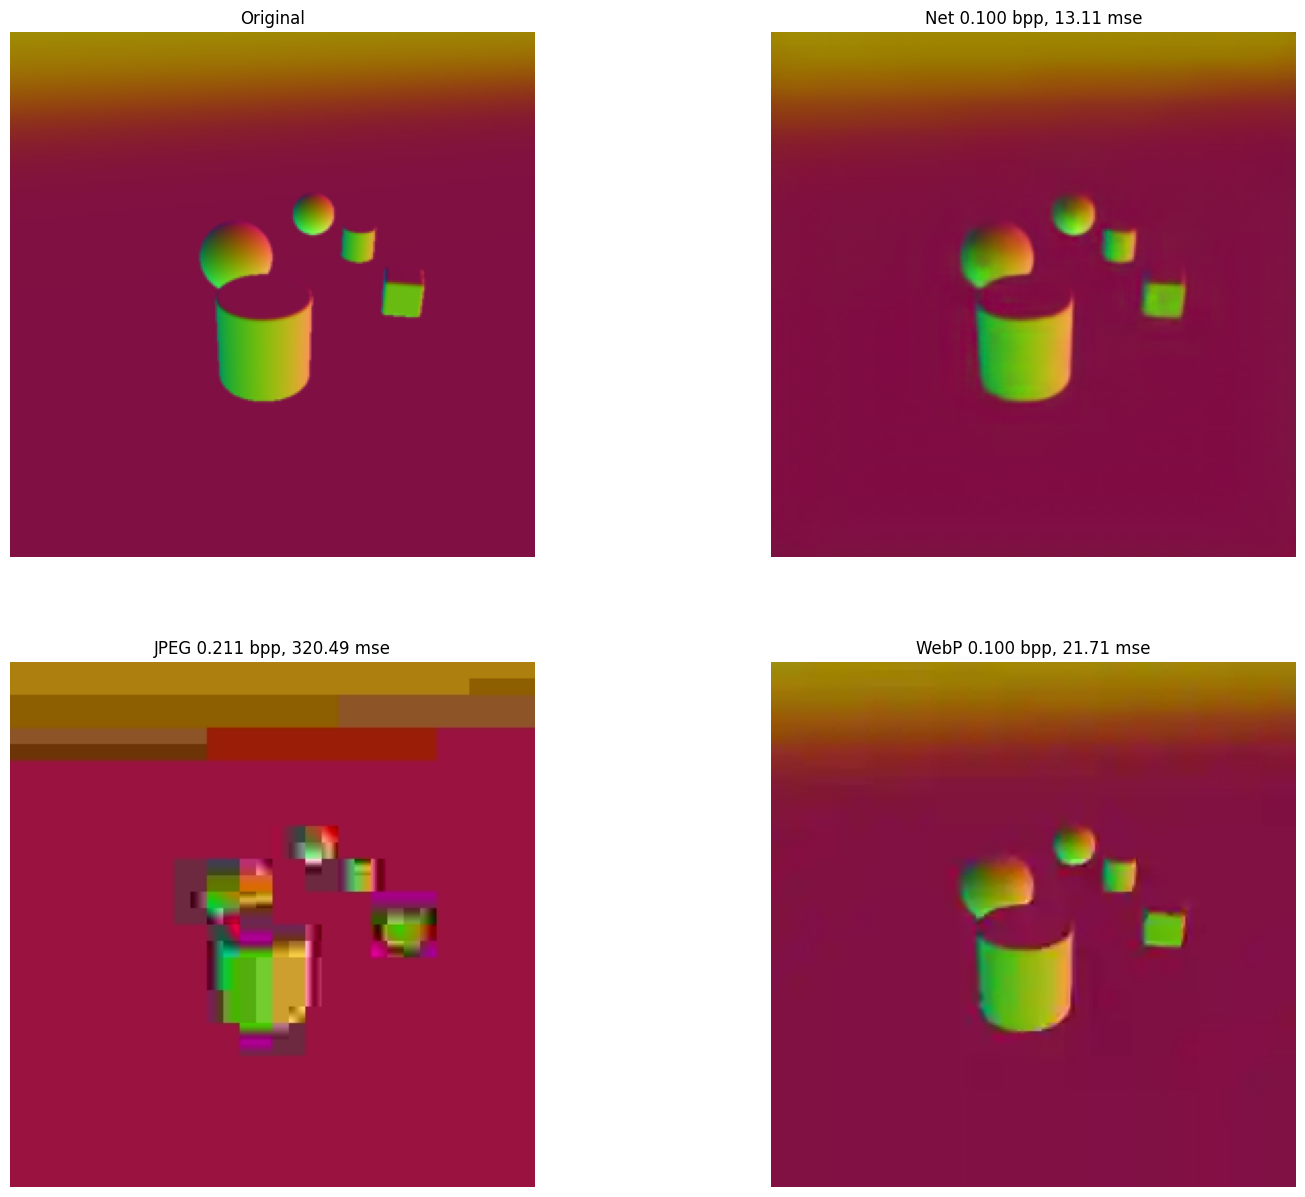

In [50]:
original_image = transforms.ToPILImage()(batch["normal"][0])

bpp, rec_net = run_pretrained_model(original_image, bmshj2018_hyperprior, quality=4)
compare_with_classical(rec_net, original_image, target_bpp=0.1)

---

### Compute MSE and BPP for JPEG

In [37]:
jpeg_ans, (jpeg_bpps, jpeg_mse) = mse_across_tasks(batch, model="JPEG")

---

### Compute MSE and BPP for Pretrained Scale Hyperprior

In [38]:
pretr_ans, (pretr_bpps, pretr_mse) = mse_across_tasks(batch, model="pretr")

---

### Rate-Distortion plots

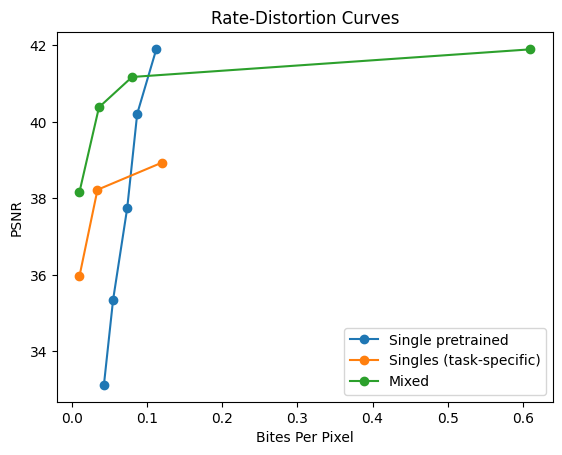

In [39]:
# {name: (bpps, dists)},
#   ...
# }
# values for lambda = 0.001 0.010 0.100 + reconstruction only
model_values = {
#                 "JPEG":                       (jpeg_bpps, jpeg_mse),

                "Single pretrained":       (pretr_bpps, pretr_mse),
    
                "Singles (task-specific)":    ([0.12, 0.034, 0.01], 
                                               np.array([8.37, 9.86, 16.6]) / 256 / 256),
#                 "Singles (task-specific)":    ([1.87, 0.12, 0.034, 0.01], 
#                                                np.array([8.27, 8.37, 9.86, 16.6]) / 256 / 256),

                "Mixed":                      ([0.61, 0.08, 0.036, 0.01], 
                                               np.array([12.7/3, 5, 6, 10]) / 256 / 256), # 5?????

#                 "Disjoint":                 ([____, ____, ____, 0.69], 
#                                              np.array([12.7/3, 5, 6, 10]) / 256 / 256),

#                 "Shared":                   ([____, ____, ____, ____], 
#                                              np.array([12.7/3, 5, 6, 10]) / 256 / 256)
               }

plot_rate_distortion_curves(model_values)

---

### Let's see how is the memmory disitributed by classes

* maybe also check how much memmory is in the z variables and how much is in the y. Remember that z is shared for all the tasks

In [ ]:
y_likelihoods = 
z_likelihoods = 
num_pixels = 256 * 256
channel_bpps = [torch.log(y_likelihoods[0, c]).sum().item() / (-math.log(2) * num_pixels)
                for c in range(y.size(1))]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()